#70. 単語ベクトルの和による特徴量

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('/content/drive/MyDrive/newsCorpora.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


In [ ]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)

In [3]:
import string
import torch

def transform_w2v(text):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #記号をスペースに置換
    words = text.translate(table).split()  # スペースで分割してリスト化
    vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

    return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [4]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([10672, 300])
tensor([[-0.0170,  0.1318, -0.0728,  ...,  0.0395,  0.0223,  0.0184],
        [-0.1119, -0.0523, -0.1002,  ...,  0.0319, -0.0237, -0.0425],
        [-0.0636, -0.0228, -0.0005,  ..., -0.0280,  0.1057,  0.0396],
        ...,
        [ 0.0301, -0.0355, -0.0082,  ..., -0.0045,  0.0606, -0.0281],
        [ 0.0002,  0.0442, -0.0424,  ..., -0.0507,  0.0283,  0.0365],
        [ 0.0242,  0.0418,  0.1211,  ..., -0.0564,  0.0144,  0.0277]])


In [5]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)

torch.Size([10672])
tensor([0, 0, 0,  ..., 0, 2, 2])


In [6]:
# ファイルに保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

#71. 単層ニューラルネットワークによる予測

In [7]:
from torch import nn

class SLPNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

    def forward(self, x):
        x = self.fc(x)
        return x

In [8]:
model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(y_hat_1)

tensor([[2.0723e-02, 4.8322e-01, 4.9574e-01, 3.1792e-04]],
       grad_fn=<SoftmaxBackward>)


In [9]:
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat)

tensor([[2.0723e-02, 4.8322e-01, 4.9574e-01, 3.1792e-04],
        [7.2529e-03, 9.4215e-01, 3.9119e-02, 1.1475e-02],
        [7.8852e-02, 8.5389e-01, 5.8620e-02, 8.6424e-03],
        [2.6431e-01, 5.5378e-01, 1.2820e-01, 5.3706e-02]],
       grad_fn=<SoftmaxBackward>)


#72. 損失と勾配の計算

In [10]:
criterion = nn.CrossEntropyLoss()

l_1 = criterion(model(X_train[:1]), y_train[:1])  # 入力ベクトルはsoftmax前の値
model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 3.8765
勾配:
tensor([[ 1.6609e-02, -1.2903e-01,  7.1246e-02,  ..., -3.8671e-02,
         -2.1816e-02, -1.7974e-02],
        [-8.1954e-03,  6.3669e-02, -3.5156e-02,  ...,  1.9082e-02,
          1.0765e-02,  8.8692e-03],
        [-8.4079e-03,  6.5319e-02, -3.6067e-02,  ...,  1.9577e-02,
          1.1044e-02,  9.0991e-03],
        [-5.3921e-06,  4.1890e-05, -2.3130e-05,  ...,  1.2555e-05,
          7.0827e-06,  5.8353e-06]])


In [11]:
l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 3.1684
勾配:
tensor([[ 5.1665e-02, -4.1399e-02,  4.3919e-02,  ..., -1.1632e-02,
         -2.2042e-02, -3.8711e-03],
        [-4.5819e-02,  1.9335e-02, -3.3342e-02,  ...,  6.6827e-03,
          1.8265e-02,  1.2697e-03],
        [-5.0148e-03,  2.0255e-02, -1.0200e-02,  ...,  4.8802e-03,
          3.7520e-03,  2.5783e-03],
        [-8.3091e-04,  1.8097e-03, -3.7671e-04,  ...,  6.9303e-05,
          2.5548e-05,  2.3109e-05]])


#73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [12]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, X, y):  # datasetの構成要素を指定
        self.X = X
        self.y = y

    def __len__(self):  # len(dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, idx):  # dataset[idx]で返す値を指定
        return [self.X[idx], self.y[idx]]

In [13]:
from torch.utils.data import DataLoader

# Datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [14]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10

for epoch in range(num_epochs):

    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
        optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 損失を記録
        loss_train += loss.item()

  # バッチ単位の平均損失計算
    loss_train = loss_train / i

  # 検証データの損失計算
    model.eval() 
    with torch.no_grad():
        inputs, labels = next(iter(dataloader_valid))
        outputs = model(inputs)
        loss_valid = criterion(outputs, labels)

  # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 1, loss_train: 0.4834, loss_valid: 0.3675
epoch: 2, loss_train: 0.3164, loss_valid: 0.3252
epoch: 3, loss_train: 0.2871, loss_valid: 0.3014
epoch: 4, loss_train: 0.2719, loss_valid: 0.2907
epoch: 5, loss_train: 0.2626, loss_valid: 0.2857
epoch: 6, loss_train: 0.2551, loss_valid: 0.2855
epoch: 7, loss_train: 0.2495, loss_valid: 0.2834
epoch: 8, loss_train: 0.2459, loss_valid: 0.2854
epoch: 9, loss_train: 0.2423, loss_valid: 0.2777
epoch: 10, loss_train: 0.2406, loss_valid: 0.2738


#74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [15]:
def calculate_accuracy(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

    return correct / total

In [16]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.921
正解率（評価データ）：0.906


#75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [17]:
def calculate_loss_and_accuracy(model, criterion, loader):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

    return loss / len(loader), correct / total

In [18]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30

log_train = []
log_valid = []

for epoch in range(num_epochs):

    model.train()
    for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
        optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

  # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')  

epoch: 1, loss_train: 0.3255, accuracy_train: 0.8873, loss_valid: 0.3436, accuracy_valid: 0.8793
epoch: 2, loss_train: 0.2865, accuracy_train: 0.9031, loss_valid: 0.3057, accuracy_valid: 0.8921
epoch: 3, loss_train: 0.2746, accuracy_train: 0.9078, loss_valid: 0.2944, accuracy_valid: 0.8996
epoch: 4, loss_train: 0.2591, accuracy_train: 0.9088, loss_valid: 0.2840, accuracy_valid: 0.8981
epoch: 5, loss_train: 0.2569, accuracy_train: 0.9098, loss_valid: 0.2839, accuracy_valid: 0.8951
epoch: 6, loss_train: 0.2450, accuracy_train: 0.9157, loss_valid: 0.2753, accuracy_valid: 0.9040
epoch: 7, loss_train: 0.2401, accuracy_train: 0.9177, loss_valid: 0.2705, accuracy_valid: 0.9018
epoch: 8, loss_train: 0.2363, accuracy_train: 0.9193, loss_valid: 0.2705, accuracy_valid: 0.9055
epoch: 9, loss_train: 0.2335, accuracy_train: 0.9214, loss_valid: 0.2704, accuracy_valid: 0.9093
epoch: 10, loss_train: 0.2314, accuracy_train: 0.9222, loss_valid: 0.2685, accuracy_valid: 0.9063
epoch: 11, loss_train: 0.2383

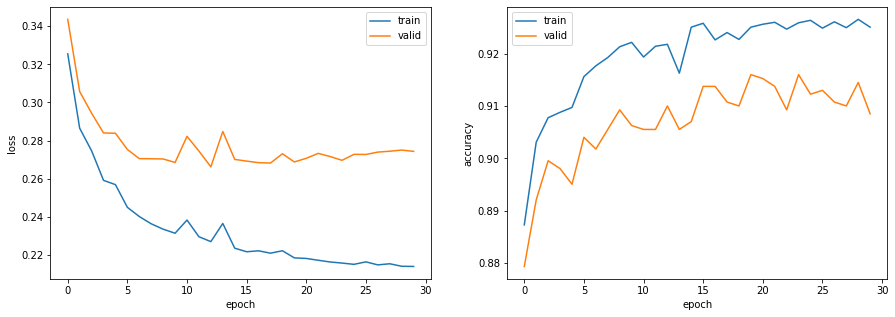

In [20]:
import numpy as np
from matplotlib import pyplot as plt

# グラフ化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

#76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [21]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
        optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

  # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

  # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

  # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')  

epoch: 1, loss_train: 0.3452, accuracy_train: 0.8736, loss_valid: 0.3550, accuracy_valid: 0.8741
epoch: 2, loss_train: 0.2881, accuracy_train: 0.9018, loss_valid: 0.3104, accuracy_valid: 0.8943
epoch: 3, loss_train: 0.2696, accuracy_train: 0.9096, loss_valid: 0.2927, accuracy_valid: 0.8981
epoch: 4, loss_train: 0.2575, accuracy_train: 0.9150, loss_valid: 0.2857, accuracy_valid: 0.9040
epoch: 5, loss_train: 0.2501, accuracy_train: 0.9151, loss_valid: 0.2780, accuracy_valid: 0.9063
epoch: 6, loss_train: 0.2445, accuracy_train: 0.9179, loss_valid: 0.2755, accuracy_valid: 0.9070
epoch: 7, loss_train: 0.2400, accuracy_train: 0.9203, loss_valid: 0.2750, accuracy_valid: 0.9085
epoch: 8, loss_train: 0.2419, accuracy_train: 0.9178, loss_valid: 0.2826, accuracy_valid: 0.8981
epoch: 9, loss_train: 0.2340, accuracy_train: 0.9203, loss_valid: 0.2694, accuracy_valid: 0.9063
epoch: 10, loss_train: 0.2353, accuracy_train: 0.9196, loss_valid: 0.2784, accuracy_valid: 0.9025


# 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列W
の値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [22]:
import time

#Bの値を変えるごとにいちいち書くのが面倒なので関数にしておく
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [25]:
# datasetの作成
# dataset_train = CreateDataset(X_train, y_train)
# dataset_valid = CreateDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]: #1,2,4,8,...と変化させていく
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.3343, accuracy_train: 0.8882, loss_valid: 0.3461, accuracy_valid: 0.8786, 4.4172sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3013, accuracy_train: 0.8988, loss_valid: 0.3144, accuracy_valid: 0.8906, 2.3258sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2937, accuracy_train: 0.9016, loss_valid: 0.3092, accuracy_valid: 0.8936, 1.2290sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2899, accuracy_train: 0.9036, loss_valid: 0.3056, accuracy_valid: 0.8943, 0.6786sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2879, accuracy_train: 0.9040, loss_valid: 0.3034, accuracy_valid: 0.8951, 0.4390sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2868, accuracy_train: 0.9032, loss_valid: 0.3023, accuracy_valid: 0.8936, 0.2979sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2865, accuracy_train: 0.9033, loss_valid: 0.3019, accuracy_valid: 0.8943, 0.2122sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2856, accuracy_train: 0.9034, loss_valid: 0.3017, accuracy_valid: 0.8943, 0.1803sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2864, accuracy_

#78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

In [26]:
def calculate_loss_and_accuracy(model, criterion, loader, device): #deviceを追加
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [27]:
# datasetの作成
# dataset_train = CreateDataset(X_train, y_train)
# dataset_valid = CreateDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1, device=device)

バッチサイズ: 1
epoch: 1, loss_train: 0.3324, accuracy_train: 0.8859, loss_valid: 0.3636, accuracy_valid: 0.8741, 9.2493sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3086, accuracy_train: 0.8982, loss_valid: 0.3409, accuracy_valid: 0.8846, 4.6618sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2965, accuracy_train: 0.8993, loss_valid: 0.3277, accuracy_valid: 0.8936, 2.4611sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2913, accuracy_train: 0.9017, loss_valid: 0.3226, accuracy_valid: 0.8951, 1.2340sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2896, accuracy_train: 0.9019, loss_valid: 0.3209, accuracy_valid: 0.8943, 0.6608sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2885, accuracy_train: 0.9025, loss_valid: 0.3201, accuracy_valid: 0.8966, 0.3944sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2883, accuracy_train: 0.9026, loss_valid: 0.3197, accuracy_valid: 0.8966, 0.2553sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2871, accuracy_train: 0.9029, loss_valid: 0.3196, accuracy_valid: 0.8966, 0.1771sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2878, accuracy_

#79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [28]:
#モデルの多層化
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(300, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 4),
        )
    def forward(self, X):
        return self.net(X)

In [29]:
model = MLP()
# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1, device=device)

バッチサイズ: 1
epoch: 1, loss_train: 0.2828, accuracy_train: 0.9024, loss_valid: 0.3073, accuracy_valid: 0.8906, 12.2310sec
バッチサイズ: 2
epoch: 1, loss_train: 0.2522, accuracy_train: 0.9096, loss_valid: 0.2787, accuracy_valid: 0.9063, 6.1124sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2054, accuracy_train: 0.9272, loss_valid: 0.2521, accuracy_valid: 0.9070, 3.1561sec
バッチサイズ: 8
epoch: 1, loss_train: 0.1975, accuracy_train: 0.9315, loss_valid: 0.2500, accuracy_valid: 0.9130, 1.6396sec
バッチサイズ: 16
epoch: 1, loss_train: 0.1925, accuracy_train: 0.9330, loss_valid: 0.2489, accuracy_valid: 0.9108, 0.8680sec
バッチサイズ: 32
epoch: 1, loss_train: 0.1897, accuracy_train: 0.9336, loss_valid: 0.2491, accuracy_valid: 0.9145, 0.4912sec
バッチサイズ: 64
epoch: 1, loss_train: 0.1891, accuracy_train: 0.9340, loss_valid: 0.2488, accuracy_valid: 0.9145, 0.3102sec
バッチサイズ: 128
epoch: 1, loss_train: 0.1906, accuracy_train: 0.9338, loss_valid: 0.2479, accuracy_valid: 0.9138, 0.1947sec
バッチサイズ: 256
epoch: 1, loss_train: 0.1878, accuracy